In [1]:
import json

import nptsne
import numpy as np
from nptsne import hsne_analysis
import pandas as pd

In [5]:
X = np.load("C:\\Users\\alexa\\Desktop\\Thumos14\\features_test_set.npy")
GT_LABELS = pd.read_csv("C:\\Users\\alexa\\Desktop\\Thumos14\\labels_test_set_gt.csv", header=0)

In [6]:
import matplotlib.pyplot as plt

def plot_analysis(analysis):
    x_coords = [point[0] for point in analysis.embedding]
    y_coords = [point[1] for point in analysis.embedding]
    
    # Create scatter plot
    plt.scatter(x_coords, y_coords, s=5, color='blue')
    
    plt.grid(True)  # Enable grid
    plt.show()

In [7]:
from collections import defaultdict
def create_uniform_hierarchy_3_scales(base = 5):
    values_scale_0 = GT_LABELS["segment_id"].to_numpy()
    values_scale_1 = GT_LABELS["segment_id"].iloc[0:len(GT_LABELS):base].to_numpy()
    values_scale_2 = GT_LABELS["segment_id"].iloc[0:len(GT_LABELS):base*base].to_numpy()
    
    scale_2 = defaultdict(list)
    for i in range(len(values_scale_2)):
        if base * (i+1) < len(values_scale_1):
            scale_2[int(values_scale_2[i])] = values_scale_1[(base*i):(base*(i+1))]
        else:
            scale_2[int(values_scale_2[i])] = values_scale_1[(base*i):]
    scale_1 = defaultdict(list)
    for i in range(len(values_scale_1)):
        if base * (i+1) < len(values_scale_0):
            scale_1[int(values_scale_1[i])] = values_scale_0[(base*i):(base*(i+1))]
        else:
            scale_1[int(values_scale_1[i])] = values_scale_0[(base*i):]
    return scale_2, scale_1

In [8]:
def create_hsne(scales = 4):
    print(f'Size data: {X.shape}')
    hsne = nptsne.HSne(True)
    hsne.create_hsne(X, scales)
    print(f'Num scales: {hsne.num_scales} Num points {hsne.num_data_points}')
    return hsne

In [9]:
def create_top_analysis(hsne, iterations = 500):
    top_analysis = nptsne.hsne_analysis.Analysis(hsne,nptsne.hsne_analysis.EmbedderType.GPU)
    for i in range(iterations):
        top_analysis.do_iteration()
    return top_analysis

In [10]:
# def create_new_analysis(hsne, points, parent_analysis, iterations = 500):
#     new_analysis = nptsne.hsne_analysis.Analysis(hsne, embedder_type= nptsne.hsne_analysis.EmbedderType.GPU, parent=parent_analysis, parent_selection=points)
#     for i in range(iterations):
#         new_analysis.do_iteration()
#     return new_analysis

In [11]:
from sklearn.cluster import AgglomerativeClustering
def create_clustering(analysis, n_clusters):
    print(np.shape(analysis.embedding))
    points = analysis.embedding
    agglomerativeClustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="single")
    agglomerativeClustering.fit(points)
    return agglomerativeClustering

In [12]:
def get_total_labels_per_class():
    unique, counts = np.unique(GT_LABELS["segment_gt_label"], return_counts=True)
    total_labels = dict(zip(unique, counts))
    return total_labels

def get_true_labels_for_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    return GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"]

def find_gt_labels_in_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    unique, counts = np.unique(GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"], return_counts=True)
    return dict(zip(unique,counts))

def find_number_of_gt_labels_in_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    return len(pd.unique(GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"]))

In [13]:
from sklearn.manifold import TSNE
class ComparableAnalysis:
    def __init__(self, number_of_points, analysis):
        self.number_of_points = number_of_points
        self.analysis = analysis
    
    def __lt__(self, other):
        return self.number_of_points < other.number_of_points
    
    def __eq__(self, other):
        return self.analysis.id == other.analysis.id
    
    
class UniformAnalysis:
    def __init__(self, parent_selection = None, scale_id = 2, parent_landmark_orig_indexes = None):
        self.scale_id = scale_id
        self.parent_selection = parent_selection
        self.parent_landmark_orig_indexes = parent_landmark_orig_indexes
        if scale_id != 2:
            self.landmark_orig_indexes = None
            self.find_landmark_orig_indexes()
            self.landmark_indexes = None
            self.find_landmark_indexes()
            self.number_of_points = None
            self.find_number_of_points()
            self.embedding = None
            self.find_embedding()
        
        
        
        
    @staticmethod
    def create_tsne_embedding(data):
        print("tsne", np.shape(data))
        iterations = 500
        if np.shape(data)[0] < 500:
            iterations = 50
        tsne = nptsne.TextureTsne(iterations=iterations)
        embedding = tsne.fit_transform(data)
        reshaped_embedding = embedding.reshape((-1,2))
        return reshaped_embedding
    
    @staticmethod
    def create_tsne_embedding_scikit(data):
        perplexity = 30
        print(np.shape(data)[0])
        if np.shape(data)[0] <= perplexity:
            perplexity = np.shape(data)[0] - 1 
        embedding = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=500, perplexity=perplexity, n_jobs=-1).fit_transform(data)
        return embedding
        
        
    
    def find_landmark_orig_indexes(self):
        # we are in scale 1, so the parent points are in scale 2
        self.landmark_orig_indexes = []
        if self.scale_id == 1:
            for point in self.parent_selection:
                for p in scale_2[self.parent_landmark_orig_indexes[point]]:
                    self.landmark_orig_indexes.append(p)
        else:
            # we are in scale 0, so the parent points are in scale 1
            for point in self.parent_selection:
                for p in scale_1[self.parent_landmark_orig_indexes[point]]:
                    self.landmark_orig_indexes.append(p)
        # print(self.landmark_orig_indexes)
    
    def find_landmark_indexes(self):
        self.landmark_indexes = list(range(len(self.landmark_orig_indexes)))
    
    def find_number_of_points(self):
        self.number_of_points = len(self.landmark_indexes)
        
    def find_embedding(self):
        # print(self.landmark_orig_indexes)
        self.embedding = UniformAnalysis.create_tsne_embedding_scikit(X[self.landmark_orig_indexes])
    
            

In [14]:
scale_2, scale_1 = create_uniform_hierarchy_3_scales()
# placeholder_hsne = create_hsne(3)
# placeholder_top_analysis = create_top_analysis(placeholder_hsne, 1)

In [15]:
top_analysis = UniformAnalysis()
print("1")
top_analysis.landmark_orig_indexes = list(scale_2.keys())
top_analysis.landmark_indexes = list(range(len(top_analysis.landmark_orig_indexes)))
top_analysis.number_of_points = len(top_analysis.landmark_indexes)
print("2")
top_analysis.embedding = UniformAnalysis.create_tsne_embedding_scikit(X[list(scale_2.keys())])
print("3")
# placeholder_top_analysis.landmark_orig_indexes = list(scale_2.keys())
# placeholder_top_analysis.landmark_indexes = list(range(len(placeholder_top_analysis.landmark_orig_indexes)))
# placeholder_top_analysis.number_of_points = len(placeholder_top_analysis.landmark_indexes)
# placeholder_top_analysis.embedding = create_tsne(X[list(scale_2.keys())])

1
2
13488
3


(13488, 2)


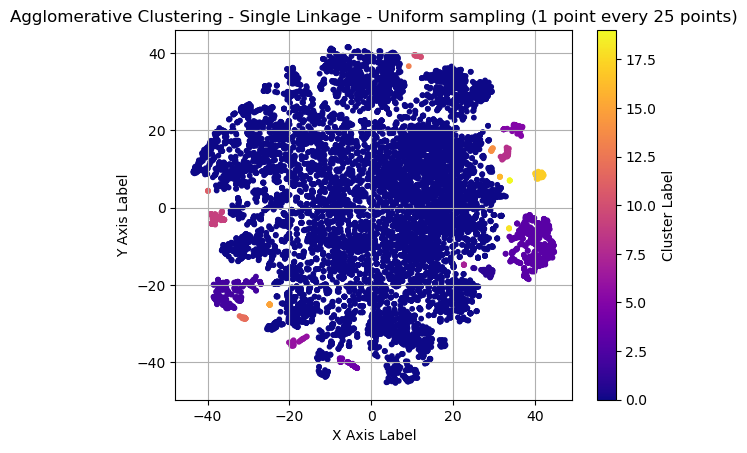

In [24]:
cluster = create_clustering(top_analysis, n_clusters= 20)

plt.scatter(top_analysis.embedding[:, 0], top_analysis.embedding[:, 1], c=cluster.labels_, cmap='plasma', s=10)
plt.title('Agglomerative Clustering - Single Linkage - Uniform sampling (1 point every 25 points)')
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [13]:
# def alter_analysis(placeholder_analysis):
#     landmark_orig_indexes = []
#     parent_ids = placeholder_analysis.parent_selection
#     print(parent_ids)
#     return None

In [14]:
from collections import defaultdict
import queue

def dfs_uniform_sampling(top_analysis, scale_2, scale_1):
    remaining_labels_per_class = get_total_labels_per_class()
    initial_labels_per_class = get_total_labels_per_class()
    complete_annotated_classes = [] 
    sum_points = 0
    annotated_classes = set()
    percentage_annotated = []
    queue_analysis = queue.LifoQueue()
    queue_analysis.put(top_analysis)
    while not queue_analysis.empty():
        print(annotated_classes)
        print("Remaining labels", remaining_labels_per_class)
        print("1")
        current_analysis = queue_analysis.get()
        if current_analysis.scale_id == 0:
            current_labels = find_gt_labels_in_analysis(current_analysis)
            print("2")
            print("Current labels", current_labels)
            print(current_analysis.number_of_points)
            sum_points += current_analysis.number_of_points
            for key in current_labels.keys():
                remaining_labels_per_class[key] -= current_labels[key]
                avg_annotated = []
                for k in initial_labels_per_class.keys():
                    avg_annotated.append((initial_labels_per_class[k] - remaining_labels_per_class[k]) / initial_labels_per_class[k])
                print(avg_annotated)
                percentage_annotated.append(sum(avg_annotated)/len(avg_annotated))
            # for key in current_labels.keys():
            #     if remaining_labels_per_class[key] > 0:
            #         remaining_labels_per_class[key] -= current_labels[key]
            #         if remaining_labels_per_class[key] <= 0.1 * initial_labels_per_class[key]:
            #             annotated_classes.add(key)
            print("3")
        # complete_annotated_classes.append(len(annotated_classes))
        avg_annotated = []
        for k in initial_labels_per_class.keys():
            avg_annotated.append((initial_labels_per_class[k] - remaining_labels_per_class[k]) / initial_labels_per_class[k])
        percentage_annotated.append(sum(avg_annotated)/len(avg_annotated))
        amount_of_labels = find_number_of_gt_labels_in_analysis(current_analysis)
        print("4")
        if amount_of_labels > 0 and current_analysis.number_of_points >= 1:
            if current_analysis.scale_id != 0:
                clustering = create_clustering(current_analysis, amount_of_labels)
                print("5")
                for label in np.unique(clustering.labels_):
                    new_points = np.where(clustering.labels_ == label)[0]
                    #don't forget to compute the embedding
                    # uniform_analysis = create_new_uniform_analysis(new_points.tolist(), current_analysis.scale_id - 1)
                    uniform_analysis = UniformAnalysis(parent_selection=new_points.tolist(), scale_id=current_analysis.scale_id - 1, parent_landmark_orig_indexes = current_analysis.landmark_orig_indexes)
                    print("tsne_done")
                    queue_analysis.put(uniform_analysis)
                print("6")
    # print(purities_per_scale)
    # print(annotated_amount)
    print(sum_points)
    print("Remaining labels", remaining_labels_per_class)
    return percentage_annotated
        
    

In [15]:
uniform = dfs_uniform_sampling(top_analysis, scale_2, scale_1)
with open("C:\\msc\\msc\\Experiments_output\\Percentage_annotated_test_features_3_scales_last_level_dfs_uniform.json", "w") as file:
    json.dump(uniform, file)

set()
Remaining labels {'Background': 230567, 'BaseballPitch': 875, 'BasketballDunk': 6705, 'Billiards': 1828, 'CleanAndJerk': 7965, 'CricketBowling': 1819, 'CricketShot': 1986, 'Diving': 9593, 'FrisbeeCatch': 1240, 'GolfSwing': 1935, 'HammerThrow': 12427, 'HighJump': 6466, 'JavelinThrow': 8317, 'LongJump': 7896, 'PoleVault': 20855, 'Shotput': 6317, 'SoccerPenalty': 1134, 'TennisSwing': 2432, 'ThrowDiscus': 3712, 'VolleyballSpiking': 3111}
1
4
(13488, 2)
5
61236
tsne_done
2575
tsne_done
205
tsne_done
270
tsne_done
245
tsne_done
1400
tsne_done
360
tsne_done
110
tsne_done
215
tsne_done
315
tsne_done
15
tsne_done
100
tsne_done
135
tsne_done
20
tsne_done
55
tsne_done
5
tsne_done
100
tsne_done
20
tsne_done
45
tsne_done
10
tsne_done
6
set()
Remaining labels {'Background': 230567, 'BaseballPitch': 875, 'BasketballDunk': 6705, 'Billiards': 1828, 'CleanAndJerk': 7965, 'CricketBowling': 1819, 'CricketShot': 1986, 'Diving': 9593, 'FrisbeeCatch': 1240, 'GolfSwing': 1935, 'HammerThrow': 12427, 'Hig

In [129]:
total_labels = get_total_labels_per_class()
current_annotated = []
c = 0
for i in range(1,len(GT_LABELS["segment_gt_label"])):
    if GT_LABELS['segment_gt_label'].iloc[i-1] != GT_LABELS['segment_gt_label'].iloc[i]:
        current_annotated.append(c)
    total_labels[GT_LABELS['segment_gt_label'].iloc[i]] -= 1
    if total_labels[GT_LABELS['segment_gt_label'].iloc[i]] == 0:
        c += 1
current_annotated.append(c+1)
print(current_annotated)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [130]:
print(len(current_annotated))

5877


In [139]:
import os
import numpy as np

classes = []
current_annotated_known = []
sorted_paths = sorted(os.listdir('C:\\Users\\alexa\\Desktop\\Features_thumos14_test\\thumos\\i3d_features'), key=lambda x: int(x[11:-4]))
final_dict = {}

for path in sorted_paths:
    c = 0
    final_dict[path[:-4]] = {}
    data = np.load(f'C:\\Users\\alexa\\Desktop\\Features_thumos14_test\\thumos\\i3d_features\\{path}')
    for row in range(0,data.shape[0]):
        final_dict[path[:-4]][c] = "Background"
        c += 1
        
with open("C:\\Users\\alexa\\Desktop\\Features_thumos14_test\\thumos\\gt_annotation\\detclasslist.txt", "r") as file:
    for line in file:
        split_line = line.split()
        classes.append(split_line[1])

f = 0
c = 0
for i,class_action in enumerate(classes):
    path = f"C:\\Users\\alexa\\Desktop\\Features_thumos14_test\\thumos\\gt_annotation\\{class_action}_test.txt"
    with open(path, "r") as file:
        for line in file:
            split_line = line.split()
            video = split_line[0]
            if split_line[0] in final_dict:
                c += 1           
                current_annotated_known.append(i)
    f = i

current_annotated_known.append(f+1)
print(current_annotated_known)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [134]:
print(len(current_annotated_known))

13432


In [140]:
with open("C:\\msc\\msc\\Experiments_output\\Linear_one_click_per_segment.json", "w") as file:
    json.dump(current_annotated_known, file)